In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

import itertools
import re

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import pymorphy2

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, precision_recall_curve, confusion_matrix

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [9]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]

In [103]:
def clean_text(text):
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())

    return text

def lemmatization(text):
    if not isinstance(text, str):
        text = str(text)
        
    words = list(word_tokenize(text))

    words_lem = []
    for w in words:
        if w[0] == '-':
            w = w[1:]
        if len(w)>1:
            if w in cache:
                words_lem.append(cache[w])
            else:
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    final_words =' '.join([i for i in words_lem if not i in stopwords])
    
    return final_words

In [133]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Часть 1. Импорт данных. Очистка, лемматизация

In [108]:
nature_materials = pd.read_csv('nature_materials.csv')
materials_express = pd.read_csv('materials_express.csv')

In [107]:
stopwords = stopwords.words('english')
morph = pymorphy2.MorphAnalyzer()
cache = {}

In [109]:
%%time
materials_express['title'] = materials_express['title'].apply(lambda x: clean_text(x), 1)
materials_express['abstract'] = materials_express['abstract'].apply(lambda x: clean_text(x), 1)

nature_materials['title'] = nature_materials['title'].apply(lambda x: clean_text(x), 1)
nature_materials['abstract'] = nature_materials['abstract'].apply(lambda x: clean_text(x), 1)

CPU times: total: 1.16 s
Wall time: 1.15 s


In [110]:
%%time
materials_express['title'] = materials_express['title'].apply(lambda x: lemmatization(x), 1)
materials_express['abstract'] = materials_express['abstract'].apply(lambda x: lemmatization(x), 1)

nature_materials['title'] = nature_materials['title'].apply(lambda x: lemmatization(x), 1)
nature_materials['abstract'] = nature_materials['abstract'].apply(lambda x: lemmatization(x), 1)

CPU times: total: 3.52 s
Wall time: 3.52 s


In [111]:
materials_express = materials_express.drop(materials_express[materials_express['abstract'].str.contains('abstract')].index)

In [112]:
nature_materials['journal'] = 1
materials_express['journal'] = 0

In [113]:
df = pd.concat([nature_materials, materials_express], ignore_index=True)

In [114]:
df = df.drop('Unnamed: 0', axis=1)

In [115]:
df['journal'].value_counts(normalize=False)

1    1634
0    1136
Name: journal, dtype: int64

In [116]:
df.sample(4)

,title,publication_date,abstract,journal
2054,wear resistance maraging steel developed direc...,2020-07-01,work presents wear study maraging steel develo...,0
1337,order causes secondary bragg peaks soft materials,2007-08-26,highly ordered soft materials exhibit bragg pe...,1
1509,atomic dynamics marangoni films liquidmetal sp...,2004-11-14,despite apparent simplicity spreading liquid m...,1
1840,facial approach synthesize tinbopani coreshell...,2021-05-01,polyaniline pani wrapped tinbo tno microspheri...,0


#### Посмотрим какие слова обладают большим весом в $abstract$ разных журналов. 

In [58]:
tfidf = TfidfVectorizer(lowercase = False)

In [59]:
nature_tfidf = tfidf.fit_transform(nature_materials['abstract'])
nature_words = pd.DataFrame(nature_tfidf.toarray(), columns = tfidf.get_feature_names_out()).sum()
nature_words.sort_values(ascending=False).head(20)

materials       34.480669
properties      25.586830
surface         23.739404
magnetic        22.776439
spin            22.664695
high            22.510137
organic         22.437400
show            21.980371
devices         21.180568
structure       21.145120
phase           21.068963
using           20.961468
energy          20.894056
cells           19.594314
molecular       19.534727
metal           19.397120
electronic      19.279241
demonstrate     19.157729
applications    18.452577
electron        18.419228
dtype: float64

In [60]:
express_tfidf = tfidf.fit_transform(materials_express['abstract'])
express_words = pd.DataFrame(express_tfidf.toarray(), columns = tfidf.get_feature_names_out()).sum()
express_words.sort_values(ascending=False).head(20)

properties       18.177722
nanoparticles    17.324214
using            16.403066
surface          15.959460
results          15.789719
high             15.193405
cells            15.072895
group            14.296913
method           13.966761
temperature      13.582006
structure        13.488489
composite        13.338046
nm               13.066698
used             13.000656
study            12.906557
films            12.527819
showed           12.295812
effect           12.037011
different        12.021354
prepared         11.998812
dtype: float64

### Часть 2. Строим классификационную модель на базе $XGBClassifier$.

In [61]:
X_train, X_test, y_train, y_test = train_test_split(df, df['journal'], 
                                                    random_state=122, 
                                                    shuffle=True, 
                                                    test_size=0.3)

In [135]:
X_test.to_csv('X_test.csv'), y_test.to_csv('y_test.csv'), 

(None, None)

In [62]:
X_train_v = tfidf.fit_transform(X_train['abstract'])

In [79]:
model = XGBClassifier(random_state=122)

In [83]:
parameters = {'learning_rate': [0.05, 0.1],
              'max_depth': [3, 5, 10],
              'n_estimators': [5, 10, 100, 1000]}


gs = GridSearchCV(model, parameters, n_jobs=5, 
                   cv=5, 
                   scoring='f1')

In [84]:
gs.fit(X_train_v, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=122, reg_alpha=None,
                                     reg_lambda=None, ...),
             n_jobs=5,
             param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [3, 5, 10],
                         'n_estimators': [5, 10, 100, 1000]},
             scoring='f1')

In [85]:
gs.best_params_

{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 1000}

In [86]:
model = gs.best_estimator_

In [121]:
pipeline = Pipeline([('abstract_selector', FeatureSelector(column='abstract')), 
                     ('abstract_tfidf', tfidf), 
                     ('clf', model)])

In [125]:
pickle.dump(pipeline, open('xgb_classifier.pipe', 'wb'))

### Часть 3. Оцениваем качество модели.

In [123]:
y_pred = pipeline.predict_proba(X_test)[:,1]

In [124]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)

print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.451198, F-Score=0.964, Precision=0.944, Recall=0.986


In [89]:
pred = pipeline.predict(X_test)

In [90]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       336
           1       0.94      0.97      0.96       495

    accuracy                           0.95       831
   macro avg       0.95      0.94      0.95       831
weighted avg       0.95      0.95      0.95       831



Confusion matrix, without normalization
[[308  28]
 [ 14 481]]


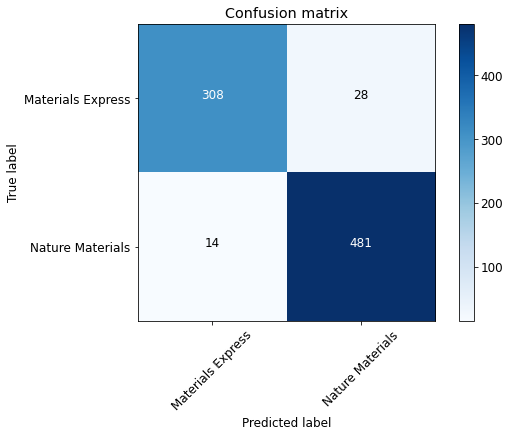

In [134]:
font = {'size' : 12}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, pred>thresholds[ix])
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cnf_matrix, classes=['Materials Express', 'Nature Materials'],
                      title='Confusion matrix', normalize=False)
plt.show()